In [68]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
from gpytorch.kernels import Kernel
import pickle
from sklearn.preprocessing import StandardScaler
from gpytorch.means import Mean
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
X_df=None
X_domain_info=None
y_df=None
with open('X_df.pkl', 'rb') as f:
    X_df = pickle.load(f)
with open('X_domain_info.pkl', 'rb') as f:
    X_domain_info = pickle.load(f)
with open('y_df.pkl', 'rb') as f:
    y_df = pickle.load(f)


print(X_df.shape)
print(y_df.shape)
num_conc=y_df.shape[1]

num_conc=y_df.shape[1]

num_feat=X_df.shape[1]
X_train, X_test, y_train, y_test= train_test_split(X_df, y_df, test_size=0.1, random_state=42)

X_train, X_test, y_train, y_test,X_D_test,y_D_test = train_test_split(X_df, y_df,X_domain_info, test_size=0.1, random_state=42)


X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

X_D_test = np.array(X_D_test, dtype=np.float32)
y_D_test = np.array(y_D_test, dtype=np.float32)

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

X_D_test = torch.tensor(X_D_test)
y_D_test = torch.tensor(y_D_test)

X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)





(274, 1084)
(274, 10)


In [70]:

mask_bool_met = X_df.columns.str.contains("HypMET")
mask_bool_mut = X_df.columns.str.contains("mut")
mask_bool_cna = X_df.columns.str.contains("cna")
mask_bool_dc  = X_df.columns.str.contains("dc")

mask_float_met = np.array(mask_bool_met, dtype=np.float32) 
mask_float_mut = np.array(mask_bool_mut, dtype=np.float32)
mask_float_cna = np.array(mask_bool_cna, dtype=np.float32)
mask_float_dc  = np.array(mask_bool_dc, dtype=np.float32)

diag_matrix_met = torch.tensor(np.diag(mask_float_met))
diag_matrix_mut = torch.tensor(np.diag(mask_float_mut))
diag_matrix_cna = torch.tensor(np.diag(mask_float_cna))
diag_matrix_dc  = torch.tensor(np.diag(mask_float_dc))
filters=(diag_matrix_mut,diag_matrix_met,diag_matrix_cna,diag_matrix_dc)
print("MUT features:"+str(np.sum(mask_float_mut)))
print("Met features:"+str(np.sum(mask_float_met)))
print("CNA features:"+str(np.sum(mask_float_cna)))
print("DC features:"+str(np.sum(mask_float_dc)))

MUT features:310.0
Met features:338.0
CNA features:425.0
DC features:0.0


In [71]:
class SigmoidMean(Mean):
    def __init__(self, input_dim, num_tasks, initial_a=None, initial_b=None):
        super(SigmoidMean, self).__init__()
        self.input_dim = input_dim
        self.num_tasks = num_tasks

        if initial_a is None:
            initial_a = torch.ones(num_tasks, input_dim)
        if initial_b is None:
            initial_b = torch.zeros(num_tasks, input_dim)

        self.register_parameter(name="a", parameter=torch.nn.Parameter(initial_a))
        self.register_parameter(name="b", parameter=torch.nn.Parameter(initial_b))

    def forward(self, x):
        # x shape: batch_size x input_dim
        # a and b shapes: num_tasks x input_dim
        # Ensure the shapes are compatible for broadcasting
        x = x.unsqueeze(1)  # Expand x to batch_size x 1 x input_dim
        a = self.a.unsqueeze(0)  # Expand a to 1 x num_tasks x input_dim
        b = self.b.unsqueeze(0)  # Expand b to 1 x num_tasks x input_dim

        # Broadcasting will happen correctly here
        sigmoid = torch.sigmoid(torch.sum(a * x + b, dim=-1))
        return sigmoid

In [72]:
class QuadripleDRPKernel(Kernel):
    def __init__(self,filters, **kwargs):
        super().__init__(**kwargs)
        self.kernel_mu = gpytorch.kernels.RBFKernel()
        self.kernel_met = gpytorch.kernels.RBFKernel()
        self.kernel_cn = gpytorch.kernels.RBFKernel()
        # self.kernel_dc = gpytorch.kernels.RBFKernel()
        self.filter_mu,self.filter_met,self.filter_cn,self.filter_dc=filters
                # Define a hyperparameter called 'scale'


        

    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        # Apply the base kernel
        filter_mu=self.filter_mu
        filter_met=self.filter_met
        filter_cn=self.filter_cn
        filter_dc=self.filter_dc
        
        x1_mu   =   x1 @ filter_mu
        x1_met  =   x1 @ filter_met
        x1_cn   =   x1 @ filter_cn
        x1_dc   =   x1 @ filter_dc

        x2_mu   =   x2 @ filter_mu
        x2_met  =   x2 @ filter_met
        x2_cn   =   x2 @ filter_cn
        x2_dc   =   x2 @ filter_dc
        bias=torch.ones(x1.shape[0], x2.shape[0])
        return self.kernel_mu(x1_mu,x2_mu)*self.kernel_met(x1_met,x2_met)*self.kernel_cn(x1_cn,x2_cn)* 1#self.kernel_dc(x1_dc,x2_dc)

In [73]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y,filters, likelihood,):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = SigmoidMean(input_dim=num_feat,num_tasks=num_conc)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            QuadripleDRPKernel(filters), num_tasks=num_conc, rank=3
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)




In [74]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_conc)
model = MultitaskGPModel(X_train_tensor, y_train_tensor,filters, likelihood)


# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# 定义学习率调度器 (每50个epoch衰减一次学习率)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
last_loss=1
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    this_loss=loss.item()
    optimizer.step()  # 更新参数
    scheduler.step()  # 更新学习率
    if abs((last_loss-this_loss)/last_loss)<0.001:
        break
    last_loss=this_loss

Iter 1/200 - Loss: 1.635
Iter 2/200 - Loss: 1.534
Iter 3/200 - Loss: 1.472
Iter 4/200 - Loss: 1.422
Iter 5/200 - Loss: 1.370
Iter 6/200 - Loss: 1.319
Iter 7/200 - Loss: 1.268
Iter 8/200 - Loss: 1.218
Iter 9/200 - Loss: 1.170
Iter 10/200 - Loss: 1.121
Iter 11/200 - Loss: 1.071
Iter 12/200 - Loss: 1.020
Iter 13/200 - Loss: 0.969
Iter 14/200 - Loss: 0.919
Iter 15/200 - Loss: 0.870
Iter 16/200 - Loss: 0.823
Iter 17/200 - Loss: 0.774
Iter 18/200 - Loss: 0.724
Iter 19/200 - Loss: 0.674
Iter 20/200 - Loss: 0.625
Iter 21/200 - Loss: 0.582
Iter 22/200 - Loss: 0.540
Iter 23/200 - Loss: 0.494
Iter 24/200 - Loss: 0.441
Iter 25/200 - Loss: 0.389
Iter 26/200 - Loss: 0.348
Iter 27/200 - Loss: 0.320
Iter 28/200 - Loss: 0.293
Iter 29/200 - Loss: 0.261
Iter 30/200 - Loss: 0.222
Iter 31/200 - Loss: 0.179
Iter 32/200 - Loss: 0.135
Iter 33/200 - Loss: 0.089
Iter 34/200 - Loss: 0.048
Iter 35/200 - Loss: 0.016
Iter 36/200 - Loss: -0.013
Iter 37/200 - Loss: -0.046
Iter 38/200 - Loss: -0.084
Iter 39/200 - Loss

torch.Size([10])
torch.Size([])
Num 22 Chosen for display
tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
[1.0879470109939575, 1.0940277576446533, 1.2931134700775146, 1.5789356231689453, 1.9644532203674316, 1.206046462059021, 0.7437816858291626, 0.39311543107032776, 0.08068293333053589, 0.08335225284099579]
[0.9120529890060425, 0.9059722423553467, 0.7068865895271301, 0.42106443643569946, 0.035546720027923584, -1.206046462059021, -0.7437816858291626, -0.39311543107032776, -0.08068293333053589, -0.08335225284099579]


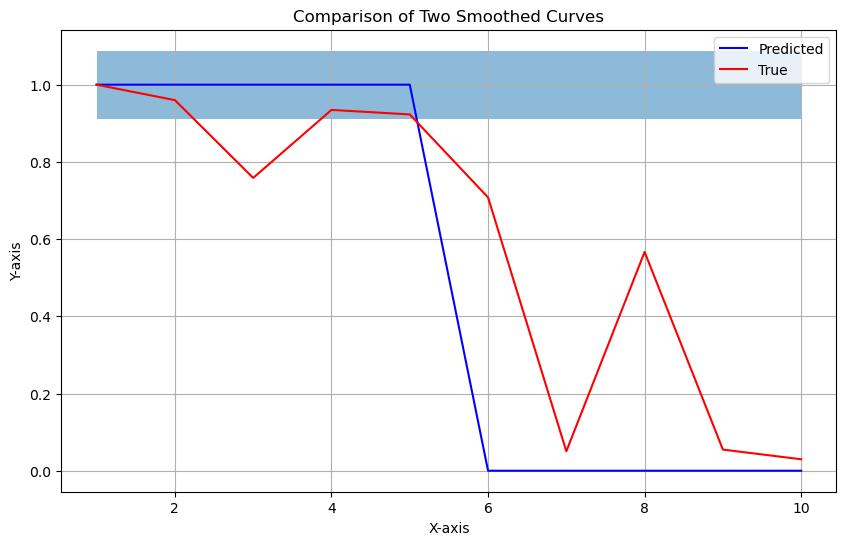

In [82]:

# Set into eval mode
model.eval()
likelihood.eval()

random_num = np.random.randint(0, len(X_test_tensor), size=1)[0]
y_true=y_test_tensor[random_num:random_num+1]

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_tensor[random_num:random_num+1]))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()


x_plt_axis = torch.tensor([1,2,3,4,5,6,7,8,9,10])

print(x_plt_axis.shape)
print(mean[0][0].shape)
print("Num "+str(random_num)+" Chosen for display")
# 创建图形、
selected_upper_bound=lower[0].numpy().tolist()
selected_lower_bound=upper[0].numpy().tolist()
print(mean.flatten())
print(selected_lower_bound)
print(selected_upper_bound)
plt.figure(figsize=(10, 6))
plt.plot(x_plt_axis, mean[0], label='Predicted', color='blue')
plt.plot(x_plt_axis, y_true[0], label='True', color='red')
plt.fill_between(x_plt_axis, selected_lower_bound[0], selected_upper_bound[0], alpha=0.5)
# 添加标题和标签
plt.title('Comparison of Two Smoothed Curves')
plt.xlabel('X-axis')
# plt.ylim(-0.5, 1.5)
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

